In [67]:
def sbm_corr(n, p, r, directed, loops):
    P = np.zeros((np.sum(n), np.sum(n)))
    block_indices = np.insert(np.cumsum(np.array(n)), 0, 0)
    for i in range(np.array(p).shape[0]):  # for each row
        for j in range(np.array(p).shape[1]):  # for each column
            P[
                block_indices[i] : block_indices[i + 1],
                block_indices[j] : block_indices[j + 1],
            ] = p[i][j]
    R = r * np.ones((np.sum(n), np.sum(n)))
    G1, G2 = sample_edges_corr(P, R, directed=directed, loops=loops)
    return G1, G2

In [70]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from graspy.plot import heatmap
from graspy.simulations import er_corr, sbm, sample_edges_corr
from graspy.utils import cartprod

mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

sns.set_context("talk")


def corrplot(corrs, rho, title=None):
    if title is None:
        title = f"Expected correlation = {rho:0.2f}"
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    sns.distplot(corrs, ax=ax)
    ax.axvline(rho, c="green", label="Expected")
    ax.axvline(corrs.mean(), c="red", label="Empirical")
    ax.set_xlabel("Correlation")
    ax.legend()
    ax.set_title(title)
    ax.spines["left"].set_visible(False)
    ax.set_yticks([])


def calculate_corr_sbm(A1, A2, block_members):
    n_per_block = block_members[0]
    assert (block_members == n_per_block).all()  # only works for isometric blocks
    n_verts = block_members.sum()
    n_blocks = len(block_members)
    inds = np.arange(n_verts)
    block_indicator = inds // n_per_block
    block_pairs = cartprod(range(n_blocks), range(n_blocks))
    block_corrs = np.empty(len(block_pairs))
    for i, bp in enumerate(block_pairs):
        mask = np.logical_and(
            block_indicator[:, np.newaxis] == bp[0],
            block_indicator[np.newaxis, :] == bp[1],
        )
        A1_edges = A1[mask]
        A2_edges = A2[mask]
        corr = np.corrcoef(A1_edges, A2_edges)[0, 1]
        block_corrs[i] = corr
    return block_corrs.mean()


def calculate_corr_er(A1, A2):
    return np.corrcoef(A1.ravel(), A2.ravel())[0, 1]

### if we set the prob. matrix for both corr_sbm and er_corr as 0.3, they perform similar as expected.

Text(0, 0.5, 'Empirical correlation')

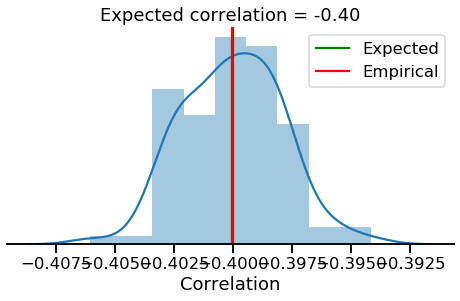

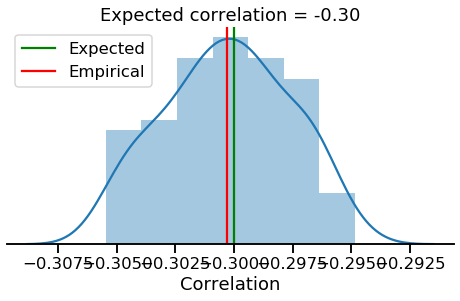

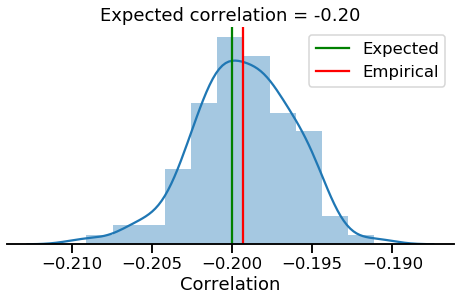

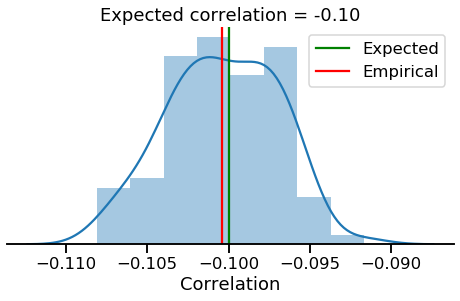

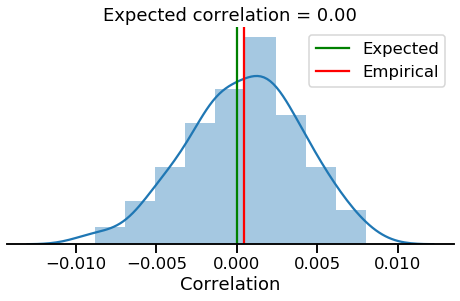

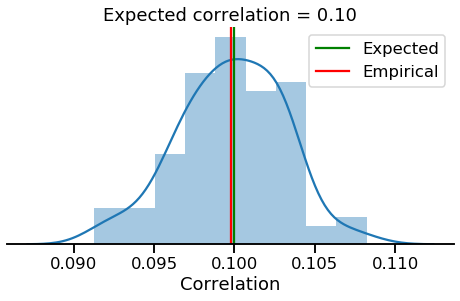

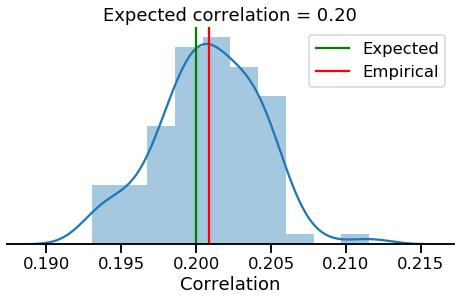

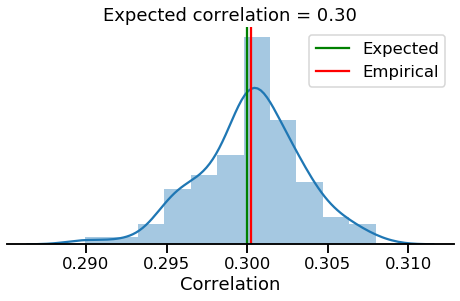

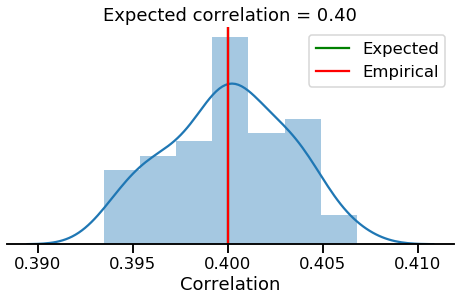

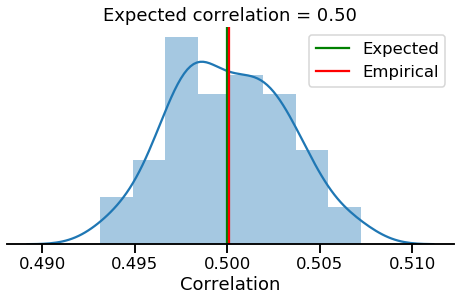

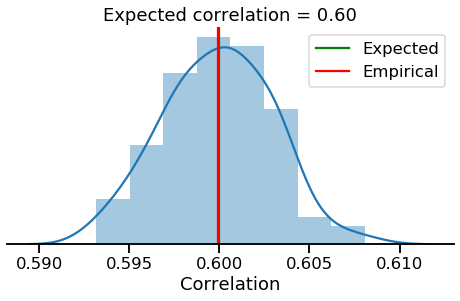

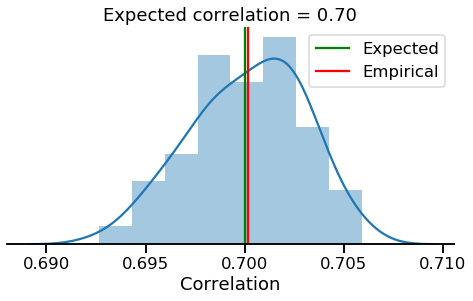

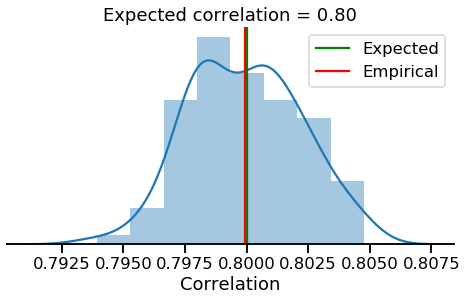

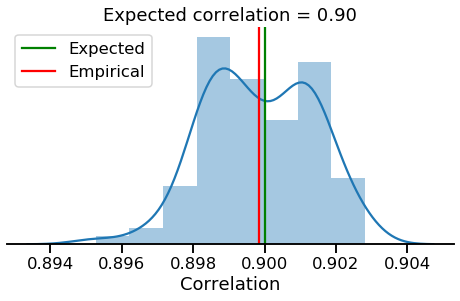

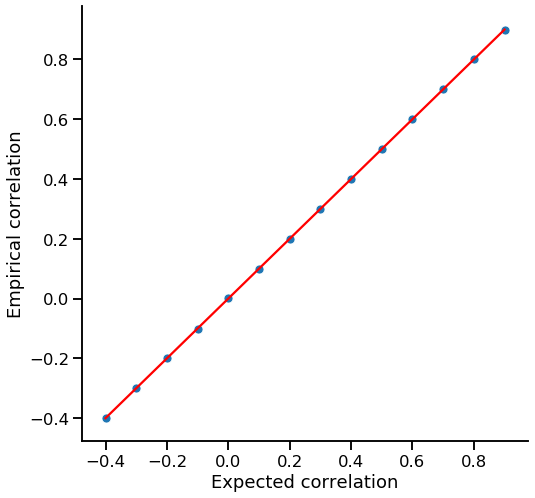

In [74]:
directed = True
loops = True
n_per_block = 100
n_blocks = 3
block_members = np.array(n_blocks * [n_per_block])
n_verts = block_members.sum()
block_probs = np.array([[0.7, 0.3, 0.4], [0.3, 0.7, 0.3], [0.4, 0.3, 0.7]])

n_sims = 100
rhos = np.linspace(-0.4, 0.9, 14)
mean_corrs = np.empty(len(rhos))
all_corrs = []
for i, rho in enumerate(rhos):
    corrs = np.empty(n_sims)
    for j in range(n_sims):
        A1, A2 = sbm_corr(
            block_members, block_probs, rho, directed=directed, loops=loops
        )
        corrs[j] = calculate_corr_sbm(A1, A2, block_members)

    mean_corrs[i] = corrs.mean()
    all_corrs.append(corrs)

    corrplot(corrs, rho)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(rhos, mean_corrs, ax=ax)
sns.lineplot(rhos, rhos, ax=ax, color="red")
ax.set_xlabel("Expected correlation")
ax.set_ylabel("Empirical correlation")

Text(0.5, 1.0, 'Correlation for rho-SBM')

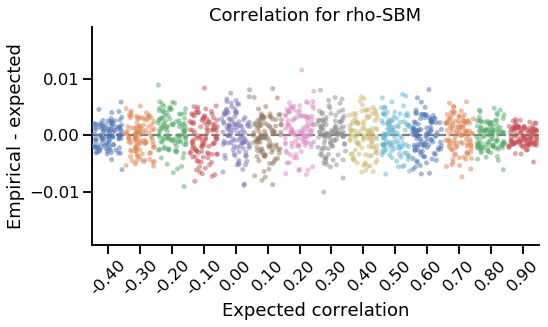

In [75]:
dfs = []
for i, corrs in enumerate(all_corrs):
    temp_df = pd.DataFrame()
    ecorr = rhos[i]
    temp_df["Empirical - expected"] = corrs - ecorr
    temp_df["Expected correlation"] = ecorr
    dfs.append(temp_df)
corr_df = pd.concat(dfs, axis=0)
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.stripplot(
    data=corr_df,
    x="Expected correlation",
    y="Empirical - expected",
    ax=ax,
    alpha=0.5,
    jitter=0.45,
    palette="deep",
)
plt.xticks(rotation=45)
ticklabels = np.vectorize(lambda x: f"{x:0.2f}")(rhos)
ax.xaxis.set_major_formatter(plt.FixedFormatter(ticklabels))
ax.axhline(0, color="grey", linestyle="--", alpha=1)
ax.set_title("Correlation for rho-SBM")